In [37]:
import sys
import os
import os.path
from os.path import exists

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"
    
import numpy as np
import math
import pandas as pd
import requests as r
from tqdm import tqdm
import random
import re
import csv
import sklearn
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest,chi2,SelectPercentile
from sklearn.manifold import TSNE
from sklearn.multioutput import MultiOutputClassifier
from sklearn.cluster import KMeans
import adjustText


from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.markers import MarkerStyle
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib import font_manager

from Bio.Align.Applications import ClustalOmegaCommandline
from Bio import AlignIO
from Bio.PDB import PDBParser
from Bio.PDB.SASA import ShrakeRupley

from pymol import cmd
from pymol import stored
from pymol import selector

import itertools

# Generate Datasets

The separate function calls other functions needed to separate the start.csv dataset into training and test sets. It calls functions to collect the fastas, pdbs, and to do the rossmann function to see if proteins are viable to be included in training/testing. It also calls a function to do the alignment/identity calculations on the viable sequences to determine the training and test sets. Includes a setting to skip file collection and sequence alignments/identity calculations if already done.

In [38]:
def separate(file_csv,run=True,rs=0):
    #collect all files if not done so already
    if run == True:
        name_label = parse_files(file_csv)
        protein_names = [i for i in name_label.keys()]
        success = pim(protein_names,folder="train")  
        if success == "False":
            print("error!")   
    #call function to generate datasets
    test_train(file_csv,rs)

The test_train function determines how to separate the proteins into training and test sets. 

First, it will remove any examples from the dataset that failed pdb or rossman checks. 

Next, it will convert the percent identity matrix files generated by the align function into dictionaries to track  shared identities. 

Next, it collects a dictionary of the substrate counts found in the dataset. If any of these examples appear less than 3 times, the associated proteins will be added to a list to be ignored, and the substrate dictionary recalculated. 

This dictionary will then be converted into a dictionary to determine how many examples for each substrate should be included in the test set (criteria for test set: if only 3 or 4 examples in dataset, add one example for that substrate to test set, otherwise add 1/5 of examples to test set). 

The dataset will then be randomized, and searched for proteins with less than 75% identitiy shared with any training sequences, and with a substrate currently less than the limits set by the dictionary. 

Once the sets are generated, they will be double checked to confirm the test set and the training set contain the same unique substrates. If the training set has unique substrates > than the test set, those associated proteins will be dropped, as otherwise the test set wouldnt be an accurate assessment. 

Finally, these sets will be written out to csv files. 

In [39]:
def test_train(file_csv,rs=0):
    df = pd.read_csv(file_csv)
    df = pd.DataFrame(df)
    #get alignment generated from pim function 
    aln = AlignIO.read( "Data/Align_Files/train/start.aln",'clustal')
    ids = [i.id.split("|")[-1] for i in aln]
    delete=[]
    
    #delete anything that failed the structure tests from the dataset
    for i in range(len(df["Name"])):  
        if df["Name"][i] not in ids:
            delete.append(i)
     
    df=df.drop(delete)

            
    substrates_temp = list(np.array(df["Donor"]))
    substrates=[]
    for i in substrates_temp:
        for j in i.split(",,"):
            substrates.append(j)

    substrates_unique = np.unique(substrates) #get list of unique substrates
    substrates_dict={i:0 for i in substrates_unique} #set dictionary for how many substrates to add to test set
    substrates_dict_track={i:0 for i in substrates_unique} #this will track current added 
    for i in substrates: #find how many examples are in total datset 
        for j in i.split(",,"):
            substrates_dict.update({j:substrates_dict[j]+1})
    count=0
    for i in substrates_dict: #convert examples to how many to add to test set
        if substrates_dict[i] <3: #remove any with less than 3 
            substrates_dict.update({i:0})
            count+=1
        elif  substrates_dict[i] == 3 or substrates_dict[i] == 4:
            substrates_dict.update({i:1})
        else:
            substrates_dict.update({i:int(substrates_dict[i]/5)})   
    df = df.sample(frac=1,random_state=rs).reset_index(drop=True) # randomize dataset

    pos_dict = {i:0 for i in np.array(df["Name"])}
    identity_dict = {i:[] for i in np.array(df["Name"])}
    pos=0
    with open("Data/Align_Files/train/pim_long.txt","r") as f: #convert pim file to two dictionaries
        for l in f:
            if len(l.split()) == 1:  
                continue
            name = l.split()[0].split("|")[-1]
            pos_dict.update({name:pos}) #update the position for each name
            matrix = l.split()[1:]
            identity_dict.update({name:matrix}) #update the identities for each name 
            pos+=1
    test_names=[]
    test_index=[]
    addition = 0
    start = True
    exclude=[]
    ex=[]
    exclude_id=[]
    
    for count,i in enumerate(np.array(df["Name"])): #iterate through names
        substrates = df["Donor"][count].split(",,") #get its substrates
        pos = pos_dict[i]
        for substrate in substrates:
            if substrates_dict[substrate] == 0: #add to exclude list if less than three examples of any donor
                exclude.append(i)
                exclude_id.append(pos)
                ex.append(substrate)  
     
    while start == True or addition != 0:
        addition = 0
        start=False
        for count,i in enumerate(np.array(df["Name"])): #iterate through names
            found=True
            substrates = df["Donor"][count].split(",,") #get its substrates
            pos = pos_dict[i]
            if pos in exclude_id:
                continue
            for substrate in substrates: 
                if substrates_dict_track[substrate] < substrates_dict[substrate]: #if current test set is less than substrate limit
                    pos = pos_dict[i]
                    for count2,j in enumerate(identity_dict[i]):
                        if count2 != pos and float(j) > 75 and count2 not in test_index and count2 not in exclude_id:
                            found=False #dont add
                    if found == True and pos not in test_index: #otherwise add
                        test_names.append(i)
                        test_index.append(pos)
                        substrates_dict_track.update({substrate:substrates_dict_track[substrate] +1})
                        addition+=1

    train_names = [i for i in np.array(df["Name"]) if i not in test_names and i not in exclude]

    substrates=[]
    substrates2=[]
    for count,i in enumerate(np.array(df["Name"])): #get substrates found in training and test sets 
        if i in test_names:
            for j in df["Donor"][count].split(",,"):
                substrates.append(j)
        if i in train_names:
            for j in df["Donor"][count].split(",,"):
                substrates2.append(j)
        
    train_names=[]
    for count,i in enumerate(np.array(df["Name"])):#check if any substrates were left out of test set due to identity
        failed=False
        if i in test_names or i in exclude:
            continue
        for j in df["Donor"][count].split(",,"): 
            if j not in substrates:
                failed=True
                break
        if failed ==False:
            train_names.append(i)
        
    substrates=[]
    substrates2=[]
    for count,i in enumerate(np.array(df["Name"])): #get num of training and test subsrates
        if i in test_names:
            for j in df["Donor"][count].split(",,"):
                substrates.append(j)
        if df["Name"][count] not in exclude and df["Name"][count] in train_names:
            for j in df["Donor"][count].split(",,"): 
                substrates2.append(j)

    #write to training and test dataset files
    split= np.array(df)
    train1= open("Data/CSV_Files/train.csv","w")
    test1= open("Data/CSV_Files/test.csv","w")
    
    train = csv.writer(train1)
    test = csv.writer(test1)
    
    train.writerow(["Name","ID","Donor","Family","Species"])
    test.writerow(["Name","ID","Donor","Family","Species"])
    
    for i in split:
        if i[0] in train_names:
            train.writerow(i)
        elif i[0] in test_names:
            test.writerow(i)
    train1.close()
    test1.close()

The get_pdb function is called to collect the AlphaFold2 structures for each protein. 

In [40]:
def get_pdb(name,folder):
    os.makedirs("Data/PDB_Files/" + folder,exist_ok=True)
    path= "Data/PDB_Files/" + folder + "/"
    url = "https://alphafold.ebi.ac.uk/files/AF-" + name + "-F1-model"
    file = path + name + ".pdb"
    if exists(file):
        return
    found=False
    for i in ["","_v1","_v2","_v3","_v4","_v5"]:
        loc = url + i + ".pdb"
        af2_pdb = r.get(loc)
        if af2_pdb.status_code == 200:
            pdb = open(file,"w")
            found=True
            pdb.write(af2_pdb.text)
            pdb.close()
            return True
    if found==False: 
        return False

The rossmann function determines the indices of the two Rossmann domains for each GT, and writes the indices to a file. It calculates secondary structure with PyMOL (writes it to file), and determines the indices of all beta strands. It then iterates through these strands and calls a recursive function to detmine which strands the current strands is h bonded to, which strands those strands are h bonded to, and so on, to determine the indices of all strands in the beta sheet. Those sheets must have at least 4 strands alternating with at least 3 helices. As some GTs will have more than 2 beta sheets meeting these conditions, the function will determine the distances between all sheet pairs, and select the sheets with the shortest distance. The first index will be the sequence-wise first beta strand's first residue and the last will be the sequence-wise second beta strand's last residue.

In [41]:
def rossmann(name,folder):
    #return if index files already exist
    pdb = "Data/PDB_Files/" + folder + "/" + name + ".pdb"
    os.makedirs("Data/Index_Files/" + folder,exist_ok=True)
    index_file="Data/Index_Files/" + folder + "/" + name + ".txt"
    if (exists(index_file)) == True:
        with open(index_file,"r") as f:
            for l in f:
                index =[int(i) for i in l.split()]
        return index,True
    
    #generate ss values with PyMOL
    os.makedirs("Data/SS_Files/" + folder,exist_ok=True)
    ss_file = "Data/SS_Files/" + folder + "/" + name + ".txt"
    if (exists(ss_file)) == False:
        cmd.load(pdb, name)
        stored.ss = []
        ss_dict = {"L":1,"H":2,"S":3," ":0}
        cmd.iterate( '(n. CA)', 'stored.ss.append(ss)')
        ss=[ss_dict[i] for i in stored.ss]
        a= open(ss_file,"w")
        for i in ss:
            a.write(str(i))
        a.close()
        cmd.delete(name)
    else:
        with open(ss_file,"r") as f:
            for l in f:
                ss = [int(i) for i in l]

    track=[]
    #determine the indices of all uninterrupted (sequence wise) groups of beta strands
    beta_sheet_groups=[]
    strand_index=[]
    for i in range(len(ss)):
        if ss[i] == 3:
            track.append(i+1)
            strand_index.append(i+1)
        if ss[i] != 3 and len(track) > 0:
            beta_sheet_groups.append(track)
            track=[]
    beta_groups_track=[]
    rossmann=[]
    index = "".join(["resi " + str(k)  + " or " for k in strand_index])[:-4]
    
    #iterate through these groups
    for i in range(len(beta_sheet_groups)):
        found=False
        
        #if this group has already been checked, continue
        for j in beta_groups_track:
            if beta_sheet_groups[i] in j:
                found=True
                
        #otherwise, call below recursion function to determinate the beta sheet this particular strand is 
        #located in
        if found==False:
            temp,beta_sheet,track = rossrecurse(ss,beta_sheet_groups[i],strand_index,name,pdb,beta_sheet_groups,
                [beta_sheet_groups[i]],[beta_sheet_groups[i]])
            beta_sheet =sorted(beta_sheet)
            beta_sheets=[]
            for j in range(1,len(beta_sheet)):
                if beta_sheet[j][0] - beta_sheet[j-1][0] > 150:
                    if len(beta_sheet[:j]) >= len(beta_sheet[j:]):
                        beta_sheets.append(beta_sheet[:j])
                    else:
                        beta_sheets.append(beta_sheet[j:])
            if len(beta_sheets) > 0:
                long=beta_sheets[0]
                for j in beta_sheets:
                    if len(j) > len(long):
                        long=j
                beta_sheet=long
                    
                
            beta_groups_track.append(beta_sheet)
            strand=False
            alternate=0
            
            #verify the beta sheet has at least 4 strands alternating with at least 3 helices
            for k in range(beta_sheet[0][-1],beta_sheet[-1][0]+1):
                if ss[int(k)-1] == 3 and strand == False:
                    strand = True
                elif ss[int(k)-1] == 2 and strand == True:
                    alternate +=1
                    strand = False
            if len(beta_sheet) <4 or alternate <3:
                continue
            rossmann.append(beta_sheet)
    distances=[]      
    
    #for all sheets that pass these conditions, determine the distances between every pair
    for i in range(len(rossmann)):
        for j in range(i,len(rossmann)):
            if i != j: #condition if overlapping sheets?
                if rossmann[i][0][0] <= rossmann[j][0][0]:
                    distances.append([abs(rossmann[j][0][0] - rossmann[i][-1][-1]),rossmann[i],rossmann[j]])
                        
                elif rossmann[j][0][0] <= rossmann[i][0][0]:
                    distances.append([abs(rossmann[i][0][0] - rossmann[j][-1][-1]),rossmann[j],rossmann[i]])
    if len(distances) == 0:
        return index,False
    
    #sort and pick the 2 sheets with the shortest distance
    distances=sorted(distances)
    beta_sheet1 = distances[0][1]
    beta_sheet2 = distances[0][2]
    if distances[0][0] < 6 and len(distances) > 1:
        beta_sheet1 = distances[1][1]
        beta_sheet2 = distances[1][2]
        
        
    
    #write these indices to file
    index = [i-1 for i in range(beta_sheet1[0][0],beta_sheet2[-1][-1]+1)]
    a = open(index_file,"w")
    a.write(" ".join([str(i) for i in index]))
    a.close()
    return index,True


The below recursive function will be called by the above function to determine beta sheet groups based on hydrogen bonds. For the current input strand group, it will calculate all h bonds. For each strand the current strand is h bonded to, the function will be called again to determine which strands that strand is h bonded to. When there are no strands in the sheet left to check, it will return a list of the sheet's strands to the above function.

In [42]:
def rossrecurse(ss,current_strand,strand_index,name,pdb,beta_sheetlist,beta_sheet,track):
    #load pdb with PyMOL
    num = "".join(["resi " + str(i) + " or " for i in current_strand])[:-4]
    cmd.load(pdb, name)
    
    #calculate h bonds between current strand and all other strands
    cmd.select("current_strand",name + " and (" + num + ") and e. n+o")
    temp_bgroups = "".join(["resi " + str(i) + " or " for i in strand_index if i not in current_strand])[:-4]
    cmd.select("other_strands",name + " and (" + temp_bgroups + ") and e. n+o") 
    hbonds = cmd.find_pairs("current_strand","other_strands",mode=1,cutoff=3.2,angle=45)
    hbonds.sort(key=lambda x:x[0][1])
    stored.resis=[]
    for atoms in hbonds:
        cmd.iterate("%s and index %s" % (atoms[1][0],atoms[1][1]), 'stored.resis.append("%s " % (resi))')
    resis = np.unique(sorted(stored.resis))
    
    #iterate through all strands
    for strand in beta_sheetlist:
        for index in resis:
            
            #if there are h bonds between funtion's current strand and loop's current strand and 
            #this loop's strand has not already been checked
            if int(index) in strand and strand not in track:
                
                #use recursion to determine h bonds of this loop
                track.append(strand)
                temp,group,track = rossrecurse(ss,strand,strand_index,name,pdb,beta_sheetlist,beta_sheet,track)
                beta_sheet.append(temp)
                break

    cmd.delete("current_strand")
    cmd.delete("other_strands")
    cmd.delete(name)
    
    #once there are no more h bonds to check in sheet, will return list of strands in sheet
    return current_strand,beta_sheet,track

This align function performs the multiple sequence alignment with  Clustal Omega. It first calls the get_pdb to collect structures. If no structure exists for a given protein input, it excludes that protein. It also calls the rossmann functions to determine the correct sequence indexing. If Rossmann domains can't be determined, that sequence will be excluded. The test set alignment to the train set MSA is done using the train MSA as a profile, and does not redo the MSA for the train set. The function also generates identity matrices for each test sequence (either full or reduced) and the training sequences, so that overly similar test sequences can be filtered out by other functions.

In [43]:
def align(names,train,folder,ross,pdb,seq,pim=True):
    path = "Data/Align_Files/"  + folder + "/"
    train_path = "Data/Align_Files/train/"  
    os.makedirs(path,exist_ok=True)
    url = "https://www.uniprot.org/uniprot/"
    
    #open fasta files
    if (train):
        fasta_short = open(path + "fasta_short.fasta","w")
        fasta_long = open(path + "fasta_long.fasta","w")
    else:
        fasta_short = open(path + "test_short.fasta","w")
        pim_fasta_short = open(path + "pim_test_short.fasta","w")
        
        fasta_long = open(path + "test_long.fasta","w")
        pim_fasta_long = open(path + "pim_test_long.fasta","w")
        
        #for identity score files, write training sequences to file
        with open(train_path+"fasta_short.fasta","r") as f:
            for l in f:
                pim_fasta_short.write(l)
                
        with open(train_path+"fasta_long.fasta","r") as f:
            for l in f:
                pim_fasta_long.write(l)   
                
    disable = False
    if train == False:
        disable=True
        
    #iterate through all input protein names

    for name in tqdm(names,disable=disable):
        check_pdb= get_pdb(name,folder)
        
        #check AF2 pdb exists
        protein_url = url + name + ".fasta"
        sequence = r.get(protein_url,verify=False)
        
        #check sequence exists
        if sequence.status_code != 200:
            #print("No sequence " + name)
            seq+=1
            if len(names)==1:
                return False,ross,pdb,seq
            continue
          
        if check_pdb == False:
           # print("No PDB " + name)
            pdb+=1
            if len(names)==1:
                return False,ross,pdb,seq
            continue
        #get Rossmann indices
        index,GT = rossmann(name,folder)
        if GT == False:
            ross+=1
            #print("No Rossmann " + name)
            if train == False:
                return False,ross,pdb,seq
            continue
            
        #format sequences for writing to file
        seq_short = "".join(sequence.text.split("\n")[1:])[index[0]:index[-1]+1]
        seq_long = "".join(sequence.text.split("\n")[1:])
        sequence_long = sequence.text.split("\n")[0] + "\n" + seq_long + "\n"
        sequence_short = sequence.text.split("\n")[0] + "\n" + seq_short + "\n"
        fasta_short.write(sequence_short)
        fasta_long.write(sequence_long)
        if not train:
            pim_fasta_short.write(sequence_short)
            pim_fasta_short.close()
            pim_fasta_long.write(sequence_long)
            pim_fasta_long.close()
    fasta_short.close() 
    fasta_long.close()
    
    #alignment

    if (train):
        #if training data, create MSA
        cmd = ClustalOmegaCommandline("/Users/shennen/clustalo", infile=path+"fasta_short.fasta",
            outfile = path + "train.aln", infmt = "fasta",outfmt="clustal",force=True,percentid=True)
    else:
        test_name = path + "test_" + str(name) + ".aln"  
        
        #if testing data and pim == true, create files with identity scorss between test sequence 
        #and all training sequences
        os.makedirs(path + folder,exist_ok=True)
        if pim == True:
            cmd2 = ClustalOmegaCommandline("/Users/shennen/clustalo", infile = path + "pim_test_long.fasta",
                distmat_out=path + "pim_long_" +str(name)+ ".txt",force=True,percentid=True,distmat_full=True)

            stdout, stderr = cmd2()
        
        #align test sequence to training MSA
        cmd = ClustalOmegaCommandline("/Users/shennen/clustalo", profile1= train_path + "train.aln", 
            profile2 = path + "test_short.fasta",outfile = test_name, outfmt="clustal",force=True)
    stdout, stderr = cmd()
    return True,ross,pdb,seq

The pim function is very similar to the above align function, and is meant to be called by the train_test and separate functions to generate the datasets. It will do the identity calculations for the full sequences to separate the dataset into training and test sets.

In [44]:
def pim(names,folder):
    path = "Data/Align_Files/"  + folder + "/"
    train_path = "Data/Align_Files/train/"  
    os.makedirs(path,exist_ok=True)
    url = "https://www.uniprot.org/uniprot/"
    
   
    fasta_long = open(path + "fasta_long.fasta","w")
    pim_fasta_long = open(path + "pim_split_long.fasta","w")
        
    #iterate through all input protein names
    count=0
    for name in tqdm(names):
        protein_url = url + name + ".fasta"
        sequence = r.get(protein_url,verify=False)
        
        #check sequence exists
        if sequence.status_code != 200:
            print("No sequence " + name)
            continue
            
        check_pdb= get_pdb(name,folder)     
        if check_pdb == False:
            print("No pdb " + name)
            continue

            
        #get Rossmann indices
        index,GT = rossmann(name,folder)
        if GT == False:
            print("No Rossmann " + name)
            continue
            
        #format sequences for writing to file
        seq_long = "".join(sequence.text.split("\n")[1:])
        sequence_long = sequence.text.split("\n")[0] + "\n" + seq_long + "\n"
        fasta_long.write(sequence_long)
        pim_fasta_long.write(sequence_long)
        if ">" not in sequence.text:
            print(sequence.text)
            print(name)
        count+=1
    pim_fasta_long.close()
    fasta_long.close()
    

    cmd2 = ClustalOmegaCommandline("/Users/shennen/clustalo", infile = path + "pim_split_long.fasta",
            distmat_out=path + "pim_long.txt",force=True,percentid=True,distmat_full=True)
    stdout, stderr = cmd2()
    
    cmd = ClustalOmegaCommandline("/Users/shennen/clustalo", infile=path+"fasta_long.fasta",
        outfile = path + "start.aln", infmt = "fasta",outfmt="clustal",force=True,percentid=True)
    stdout, stderr = cmd()
    return True

The below function reads in the csv acceptor/donor info files, and constructs a dictionary item for each sequence of name -> substrate. In the case of the test set, it confirms that each sequence has a donor that in found in the train set donors if the retrict boolean ==True, and ignores a sequence otherwise.

In [45]:
def parse_files(file_csv,train_substrates=[],restrict=True):
    df = pd.read_csv(file_csv)
    df = pd.DataFrame(df)
    names = [i for i in df["ID"]]
    substrates = [i for i in df["Donor"]]
    name_label = {}
    train=True
    if len(train_substrates) > 0:
        train=False
    train_substrates=np.array(train_substrates)
    for i in range(len(names)):
        not_found=False
        #if any substrate in a test sequence's labels is not found in training dataset, ignore
        for j in substrates[i].split(",,"): 
            if (train==False and restrict==True) and (j not in train_substrates or j == "Null"):
                not_found=True
                break
        if not_found == True:
            continue
        name_label.update({str(names[i]):[substrates[i]]})
    return name_label

The following function constructs a dataframe with the information from the above function. The dataframe also includes the sequences from the multiple sequence alignment. The function also will check if the alignment files already exist, so to not unnecessarily repeat the alignments, as this is slow. If the input arguments include a cutoff value, the test sequences with an identity score to at least one training sequence above the cutoff will be filtered out of the test dataset.

In [46]:
def aln_files(name_label,protein_names,folder,ross,pdb,seq,train=True,cutoff=100,pim=True):
    name_seq ={}
    start=True
    found=False
    path = "Data/Align_Files/" + folder + "/"
    #filter similar sequences out
    if ((train) and exists(path+"train.aln")) or (train==False and 
        exists(path + "test_" + protein_names[0] + ".aln")):
        if not train and cutoff != 100:
            with open(path+"pim_long_" + protein_names[0] + ".txt","r") as f:
                l = f.readlines()[-1]
                scores = l.split()
                for count,i in enumerate(scores[1:]):
                    if count==len(scores[1:])-1:
                        continue
                    if (float(i)) >= cutoff:
                        return pd.DataFrame(),False,ross,pdb,seq
      
    #construct alignments if not done so already
    else:
        success,ross,pdb,seq = align(protein_names,train,folder,ross,pdb,seq,pim)   
        if success==True and train == False and exists(path+"pim_" + protein_names[0] + ".txt"
        ) and exists(path + "test_" + protein_names[0] + ".aln") == False:
                
            print("Failed: " + protein_names[0])
            return pd.DataFrame(), False,ross,pdb,seq
        if success==False:
            return pd.DataFrame(), False,ross,pdb,seq
    alignname = path + "test_" + protein_names[0] + ".aln"
    if (train):
        alignname = path + "train.aln"
        
    #read the sequences for each protein
    if train == False:
        for i in protein_names:
            pdbs = "Data/PDB_Files/" + folder + "/" + i + ".pdb"
            ss = "Data/SS_Files/" + folder + "/" + i + ".txt"
            if exists(pdbs) == False or exists(ss) == False:
                print("not found " + ss)
                return pd.DataFrame(),False,ross,pdb,seq
    with open(alignname,"r") as aligner:
        alignment = AlignIO.read(open(alignname), "clustal")
        for record in alignment:
            name_seq.update({str(record.id).split("|")[1]:str(record.seq)})
            
    #put information into dataframe
    
    keys = [ i for i in name_seq.keys()]
    col =  ["Name"] + [str(i) for i in range(len(name_seq[keys[0]]))] + ["Label"]
    npdf = [] 
    for count,i in enumerate(name_seq.keys()):
        if count == (len(name_seq.keys()) - 1) or train:
            if i in name_label.keys():
                row = [i] + [j for j in name_seq[i]] + [name_label[i][0]]
            else:
                return pd.DataFrame(),False,ross,pdb,seq
        else:
            row = [i] + [j for j in name_seq[i]] + ['0']  
        npdf.append(row)
    df = pd.DataFrame(np.array(npdf),columns=col)
    return df,True,ross,pdb,seq


The below function is specific to the training files, and will call the above two functions to get the training set dataframe.

In [47]:
def train_files(file_csv): 
    name_label = parse_files(file_csv) 
    protein_names = [i for i in name_label.keys()]
    df,success,ross,pdb,seq = aln_files(name_label,protein_names,"train",0,0,0) 
    return df

The below function is specific to the test sets, and will call the parse_files function to get the testing set dataframe. For each sequence, it will call the align function to construct a MSA with the training sequences. As the MSA to the training set profile will add gapped positions to the training MSA, any positions in the test set that correspond to these added gapped positions will be removed. It then constructs a new dataframe with these shortened sequences. In short, this function creates equal sequence lengths between the test and train sequences.

In [48]:
def test_files(file_csv,df_train,cutoff=100,restrict=True,pim=True):
    name_label = parse_files(file_csv,df_train["Label"],restrict)
    folder = file_csv.split("/")[-1].split(".")[0]
    species=file_csv.split(".csv")[0].split("/")[-1]
    df=[]
    protein_names = [i for i in name_label.keys()]
    #for each sequence in test set
    ross=0
    pdb=0
    seq=0
    for j in tqdm(range(len(protein_names))):
        index_file="Data/Index_Files/" + species + "/" + protein_names[j] + ".txt"
        name=protein_names[j]
        #get dataframe of sequence+label information
        try:
            df_test,success,ross,pdb,seq = aln_files(name_label,[name],folder,ross,pdb,seq,False,cutoff,pim)
        except Exception as e:
            print(e)
            continue
        if success == False:
            continue
        #get training MSA with the extra gapped positions
        columns = df_test.columns[1:-1]
        test_seqs = np.array(df_test[columns]) 
        count=0
        delete_list =[]
        np_train = np.array(df_train[df_train.columns[1:-1]])
        #remove gapped positions
        for i in range(len(columns)):
            
            if count >= len(df_train.columns[1:-1]) or np.array_equal(test_seqs[:len(df_train)][:,i],
                np_train[:,count]) == False:
                
                delete_list.append(i)
            else:
                count+=1 
        test_seqs = np.delete(test_seqs,delete_list,1)
        #add the shortened test sequence information to test set dataframe
        test_seqs= test_seqs[len(df_train):]
        df_test = df_test[len(df_train):] 
        row = list(df_test["Name"])  + list(test_seqs[0]) + list(df_test["Label"])
        df.append(row) 
    print("No Ross: " + str(ross))
    print("No PDB: " + str(pdb))
    print("No Seq: " + str(seq))
    temp_col = [str(i) for i in range(len(df[0])-2)]
    cols = ["Name"] + temp_col + ["Label"]
    df_test = pd.DataFrame(np.array(df),columns=cols)
    return df_test

# Featurization

The following residue values were taken from this database https://www.genome.jp/dbget-bin/www_bfind?aaindex, as used in the Taujale et al. (2020) paper. The function creates dictionaries for each amino acid with hydrophobicity, volume, accesible surface area, polarity, and charge. All values are scaled between 0 and 1 to prevent the feature selection tool from only considering the largest values.

In [49]:
def normalizedata(data,mini="",maxi=""):
    if mini =="":
        return(data-np.min(data))/(np.max(data)-np.min(data))
    else:
        return(data-np.min(mini))/(np.max(maxi)-np.min(mini))

In [50]:
def dicts():
    res = ["A","R","N","D","C","E","Q","G","H","I","L","K","M","F","P","S","T","W","Y","V","X"]
    hydro_scores = normalizedata([.61,.60,.06,.46,1.07,.47,0,.07,.61,2.22,1.53,1.15,1.18,2.02,1.95,0.05,0.05,2.65,
        1.88,1.32])
    vol_scores =  normalizedata([52.6,109.1,75.7,68.4,68.3,84.7, 89.7,36.3,91.9,102.0, 102.0,105.1,97.7,113.9,
        73.6,54.9,71.2,135.4,116.2,85.1])
    asa_scores =  normalizedata([93.7,250.4,146.3,142.6,135.2,182.9,177.7,52.6,188.1,182.2,173.7,215.2,197.6,
        228.6,0.,109.5,142.1,271.6,239.9,157.2])
    polar_scores = normalizedata([8.1,10.5,11.6,13.0,5.5,12.3,10.5,9.0,10.4,5.2,4.9,11.3,5.7,5.2 ,8.0,9.2,8.6,
        5.4,6.2,5.9])
    charge_scores = normalizedata([0.,1.,0.,-1.,0.,-1.,0.,0.,0.,0.,0.,1.,0.,0.,0.,0.,0.,0.,0.,0.])
    res_dict = {res[i]: [hydro_scores[i],vol_scores[i],asa_scores[i],polar_scores[i], charge_scores[i]] 
        for i in range(len(res)-1)}
    return res_dict

The res matrix tracks positions in the sequences to help assign sasa and secondary structure values to the correct positions.

In [51]:
def make_res_matrix(df):
    np_df = np.array(df[df.columns[1:-1]]).copy()
    positions = np.array(df[df.columns[1:-1]]).copy()
    for count,sequence in enumerate(np_df):
        track=0
        for count2,aa in enumerate(sequence):
            if aa == "-":
                positions[count][count2] = -1
            else:
                positions[count][count2] = track
                track+=1
    return positions        
        

The below functions calculate sasa and gets the secondary structure values that were previously generated for each sequence and its pdb structure, and writes this information out to files, so that values do not need to be recalculated. Low confidence AF2 residues (<70) will receive values of 0.

In [74]:
def sasa_ss(name,folder):
    file = "Data/PDB_Files/" + folder + "/" + name + ".pdb"

    #calculate sasa
    struct = PDBParser(QUIET=1).get_structure(name, file)
    sr = ShrakeRupley().compute(struct, level="R")
    sasa=[]
    for chain in struct[0]:
        for res in chain:
            sasa.append(res.sasa)

    #get ss informatiom from file
    ss_file = "Data/SS_Files/" + folder + "/" + name + ".txt"
    with open(ss_file,"r") as f:
        for l in f:
            ss = [int(i) for i in l]
    index_file = "Data/Index_Files/" + folder + "/" + name + ".txt"
    
    #get Rossmann index information from file
    with open(index_file,"r") as f:
        for l in f:
            index = [int(i) for i in l.split()]

    
    #If AF2 confidence < 70, give 0 values
    with open(file,"r") as f:
        for l in f:
            info = l.split()
            if info[0] == "ATOM" and len(info[4]) > 1:
                res_num=int(info[4][1:])-1
            elif info[0] == "ATOM":
                res_num =int(info[5])-1
            if info[0] == "ATOM" and float(info[-2]) < 70 :
                sasa[res_num] =0
                ss[res_num]=0
                
    #reduce sasa and ss to Rossmann indices and scale data
    sasa= sasa[index[0]:index[-1]+1]
    ss= ss[index[0]:index[-1]+1]
    sasa = normalizedata(sasa)
    ss= normalizedata(ss,mini=0,maxi=3)
    return sasa,ss

This featurizes each sequence in the sequence alignment file, using the dictionary from above. It converts each residue at a specific position across all sequences to those 5 features, and adds this information to a new dataframe, along with the sasa and secondary structure values. The secondary structure and sasa are only calculated for residues with high confidence. If an entire structure is low confidence, that sequence and structure will be dropped from the dataset. Finally, only columns with less than 90% correlation to other columns will be included in the dataset to remove redundant information. If the sequence alignment has gaps, it assigns 0s for each feature. 

In [53]:
def featurize(df,folder,train=True,delete2=[],to_drop=[]):  
    folder=folder.split("/")[-1].split(".")[0]
    res_dict = dicts()
    sequence = df.columns[1:-1]
    all_sasa=[]
    all_ss=[]
    drops=[]
    
    
    #call above functions to get ss and sasa values for all sequences
    for count,i in enumerate(df["Name"]):
        sasa,ss = sasa_ss(i,folder)
        if np.sum(ss) == 0 or np.sum(sasa) == 0:
            drops.append(count)
            print("low confidence structure, dropped: " + i)
            continue
        all_sasa.append(sasa)
        all_ss.append(ss)

    #drop any sequences with structures with all residues < 70 confidence
    print("drop: " + str(len(drops)))
    df.drop(drops,axis=0,inplace=True)
    df.reset_index(drop=True,inplace=True)
    res_matrix = make_res_matrix(df)

    delete=[]
    
    #generate empty feature matrix
    if train:
        for i in df.columns[1:-1]:
            aa = np.array(df[i])
            if train and len(aa[aa=="-"]) > (len(aa))/2:
                delete.append(i)
        feature_matrix=np.zeros((len(df),7*(len(df.columns[1:-1])-len(delete))))
    else:
        feature_matrix=np.zeros((len(df),7*(len(df.columns[1:-1])-len(delete2))))

    count=0
    columns_all=["Name"]
    #assign featurization values
    print("delete: " + str(len(delete)))
    for i in df.columns[1:-1]:
        if (train and i in delete) or (train == False and i in delete2):
            continue
        aa = np.array(df[i])
        for j in range(len(aa)):
            if aa[j] != "-" and aa[j] != "X"  and aa[j] != "*":
                res_num = res_matrix[j][int(i)]
                if res_num==-1:
                    feature_matrix[j][(7*count)+5] = 0
                    feature_matrix[j][(7*count)+6] = 0
                else:
                    feature_matrix[j][(7*count)+5] = all_sasa[j][res_num]
                    feature_matrix[j][(7*count)+6] = all_ss[j][res_num]
                res = res_dict[aa[j]]
                for k in range(5):
                    feature_matrix[j][(7*count)+k] = res[k]
            
        count+=1
        columns=[str(i)+"_hydro",str(i)+"_vol",str(i)+"_asa",str(i)+"_polar",str(i)+"_charge",str(i)+"_sasa",
            str(i)+"_ss"   ]
        for j in columns:
            columns_all.append(j)
            
    matrix =[]
    for count,i in enumerate(feature_matrix):
        mtx = [df["Name"][count]]
        for j in i:
            mtx.append(j)
        mtx.append(df["Label"][count])
        matrix.append(mtx)
    columns_all.append("Label")
    df_new=pd.DataFrame(matrix,columns=columns_all)
    
    #remove columns with > 90% correlation
    if train:
        cor_matrix = df_new[df_new.columns[1:-1]].corr().abs()
        upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
        to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
    print("corr: " + str(len(to_drop)))
    df_new = df_new.drop(to_drop, axis=1) 
    return df_new,delete,to_drop

# Convert labels to numeric values

This converts the donor labels to numerical values (training requires numerical labels) and adds these numerical values to the dataframe. Also constructs a dictionary between the labels and numerical labels to be used by other functions.

In [54]:
def gen_labels(df_train):  
    names = df_train["Name"]
    temp_labels = (df_train["Label"])
    labels=[]
    label_num={}
    track=0
    
    #Each substrate for a sequence is separated by a ",," in the csv file
    for i in temp_labels:
        temp=i.split(",,")
        labels.append(temp)
        for j in temp:
            if j not in label_num.keys():
                label_num.update({j:track})
                track+=1
    label_ids = np.zeros((len(names),len(label_num)))
    for count,i in enumerate(labels):
        for j in i:
            label_ids[count][label_num[j]] = 1
    df_label = pd.DataFrame({"Label_Num":[[i] for i in label_ids]})
    df_train = pd.concat([df_train,df_label],axis=1)
    return df_train,label_num

This is for assigning the same numerical labels from the training dataset to the testing labels.

In [55]:
def testing_labels(df_test,label_num): 
    labels=[]
    temp_labels = (df_test["Label"])
    for i in temp_labels:
        temp=i.split(",,")
        labels.append(temp)
    label_ids = np.zeros((len(df_test),len(label_num)))
    for count,i in enumerate(labels):
        for j in i:
            label_ids[count][label_num[j]] = 1
    df_label = pd.DataFrame({"Label_Num":[[i] for i in label_ids]})
    df_test = pd.concat([df_test,df_label],axis=1)
    return df_test

# Split data

The following split function uses the selectkbest chi2 function to select the best features. 

In [56]:
def split(df_feat,n_input): 
    
    y_train = [i[0] for i in df_feat["Label_Num"]]
    columns = df_feat.columns[1:-2]
    X_train = np.array(df_feat[columns])
    selected=SelectKBest(chi2,k=n_input)
    selected_columns=selected.fit(X_train, y_train).get_feature_names_out(columns)
    X_train = selected.fit_transform(X_train, y_train)
    return y_train, X_train,selected_columns

# Training

The following functions train the model. Each function uses a grid search method with cross validation for hyperparameter tuning to produce a multi-output classifier, and uses leave-one-out cross-validation for assessment. 

In [57]:

def trainSVC(X_train ,y_train,parameter_input):
    parameters = {'estimator__C':parameter_input[0],"estimator__kernel":parameter_input[2],'estimator__gamma'
        :parameter_input[1],'estimator__max_iter':parameter_input[3]}
    sv = SVC(random_state=0,probability=True)
    #construct a multi-output classifier of SVCs
    mtf = MultiOutputClassifier(sv,n_jobs=-1)
    cv = cross_val(X_train,y_train)
    #perform grid search to find best parameters with leave one out cross validation   
    clf = GridSearchCV(mtf, parameters,cv=cv,scoring='f1_samples')
    clf.fit(X_train, y_train)
    return clf,clf.cv_results_

In [58]:
def trainRF(X_train ,y_train,parameter_input):
    parameters = {'estimator__n_estimators':parameter_input[0],'estimator__max_features':parameter_input[1],
        "estimator__criterion": parameter_input[2],"estimator__class_weight":parameter_input[3]}
    #construct a multi-output classifier of binary random forests
    rf = RandomForestClassifier(random_state=0,warm_start=True,n_jobs=-1)
    mtf = MultiOutputClassifier(rf,n_jobs=-1)
    cv = cross_val(X_train,y_train)
    #perform grid search to find best parameters with leave one out cross validation   
    clf = GridSearchCV(mtf, parameters,cv=cv,scoring='f1_samples')
    clf.fit(X_train, y_train)
    return clf,clf.cv_results_

In [59]:
from sklearn.metrics import make_scorer,hamming_loss
def trainKNN(X_train ,y_train,parameter_input):
    parameters={"estimator__n_neighbors":parameter_input[0],"estimator__p":parameter_input[1],"estimator__weights":
        parameter_input[2]}
    y_train=np.array(y_train)
    knn = KNeighborsClassifier(n_jobs=-1)
    #construct a multi-output classifier of binary KNNs
    mtf = MultiOutputClassifier(knn,n_jobs=-1)
    cv = cross_val(X_train,y_train)
    #perform grid search to find best parameters with leave one out cross validation  
    clf = GridSearchCV(mtf, parameters,cv=cv,scoring='f1_samples')
    clf.fit(X_train, y_train)
    return clf,clf.cv_results_


In [60]:
def trainGNB(X_train ,y_train,parameter_input):
    parameters={"estimator__var_smoothing":parameter_input[0]}
    gnb = GaussianNB()
    mtf = MultiOutputClassifier(gnb,n_jobs=-1)
    cv = cross_val(X_train,y_train)
    #construct a multi-output classifier of binary GNBs
    clf = GridSearchCV(mtf, parameters,cv=cv,scoring='f1_samples')
    clf.fit(X_train, y_train)
    return clf,clf.cv_results_

The grid search requires that the cross validation sets be a generator object specifiying the indicies of the relevant sets, so the below function just returns these generators.

In [61]:
def cross_val(X_train,y_train):
    loo=LeaveOneOut()
    cv=loo.split(X_train)
    for train,test in cv:
        yield train,test

# Hyperparameter Tuning

The three functions below select the optimal feature lengths and hyperparameters.

The helper_hp functions calls the training functions with the hyperparameters to be used in the grid search. 

The grid search has default values, but can accept user input as well (useful for when optimal values have already been found). 

In [62]:
def helper_hp(model,df_train,n_split,parameters):
    train_labels, train_feat,col = split(df_train,n_split)
    temp =pd.DataFrame(train_feat,columns=col)
    temp.to_csv("/Users/shennen/Desktop/featurized.csv")
    if model=="RF":
        if len(parameters)==0:
            parameters=[[i for i in range(20,201,20)],[0.1,0.3,0.5],['gini','entropy'],['balanced',
                'balanced_subsample']]
        estim,cv_results = trainRF(train_feat,np.array(train_labels),parameters)
    elif model=="SVC":
        if len(parameters)==0:
            parameters=[[0.1,1,10],[1,0.1,0.01],['linear','rbf', 'poly'],[10,50,100]]
        estim,cv_results = trainSVC(train_feat,np.array(train_labels),parameters)
    elif model=="GNB":
        if len(parameters)==0:
            parameters=[np.logspace(0,-9, num=100)]
        estim,cv_results = trainGNB(train_feat,np.array(train_labels),parameters)
    elif model=="KNN":
        if len(parameters)==0:
            parameters=[[1,2,3,4,5,6,7,8,9,10],[1,2],["uniform","distance"]]
        estim,cv_results = trainKNN(train_feat,np.array(train_labels),parameters)
    elif model=="CON":
        if len(parameters)==0:
            parameters=[[1,2,3,4,5,6,7,8,9,10],[1,2],["uniform","distance"],[i for i in range(20,201,20)],[0.1,0.3,0.5],['gini','entropy'],['balanced',
                'balanced_subsample'],[0.1,1,10],[1,0.1,0.01],['linear','rbf', 'poly'],[10,50,100]]
        estim,cv_results = trainCON(train_feat,np.array(train_labels),parameters)
    return estim,col,train_feat,cv_results 

Hp_print prints the results of the best feature length and hyperparameters.

In [63]:
def hp_print(file,model_name,best_score,best_features,best_estimator,test_score,best_params):
    os.makedirs("output/",exist_ok=True)
    a = open(file,"a")
    a.write(model_name + "\n")
    a.write("Best score: " + str(best_score)+ "\n")
    a.write("Best feature length: " + str(best_features)+ "\n")
    a.write("Best estimators: " + str(best_estimator)+ "\n")
    a.write("Testing Score: " + str(test_score)+ "\n")
    a.write("Testing Parameters: " + str(best_params)+ "\n")
    a.close()

The below function iterates through different feature lengths, where the features are defined as the best features by the above split function. For each iteration, it will call the training functions, which will then perform a parmeter grid search and return the best parameters for that feature length.  

After completing these steps, the best scores, parameters and feature lengths will be printed to a text file.

In [64]:
def hp(model_name,df_train,df_test,label_num,parameters=[],search_range=0):
    if search_range == 0:
        search_range = [i for i in range(50,1001,50)]
    best_score=0

    #for each length. in the feature length search
    for count,i in tqdm(enumerate(search_range)):

        #perform a grid search
        estim,col,train_feat,cv_results  = helper_hp(model_name,df_train,i,parameters)
        #estim,col,train_feat  = helper_hp(model_name,df_train,i,parameters)
        cv_results.update({"features":[len(col) for j in range(len(list(cv_results['rank_test_score'])))]})

        #print highest scores for all feature lengths
        if estim.best_score_ > best_score:
            best = estim
            best_score=estim.best_score_
            feature_length=train_feat.shape[1]
            best_train_feat=train_feat
            best_col=col
            best_test_score=evaluate(best,model_name,df_test,best_col,False,label_num)

            hp_print("output/track.txt", model_name,best.best_score_,feature_length,
                best.best_estimator_,best_test_score,best.best_params_)

            if best.best_score_ == 1:
                break

    evaluate(best,model_name,df_test,best_col,False,label_num,mcc_output = True)


    hp_print("output/best.txt", model_name,best.best_score_,
        feature_length,best.best_estimator_,best_test_score,best.best_params_)

    print("Best score: " + str(best.best_score_))
    print("Best feature length: " + str(feature_length))
    print("Best estimators: " + str(best.best_estimator_))
    print("Testing Score: " + str(best_test_score))
    print("Best parameters: " + str(best.best_params_))

    return best,best_col

# Model Evaluation and Application

This function evaluates the model, by scoring the predictions versus real labels. The testing sequences will only use the same features as selected by the feature selection. It also outputs the exact predictions if the verbose argument == True. This function also optionally returns MCC scores for each substrate.

In [65]:
def evaluate(model,model_name,df_test,columns,verbose,label_num,mcc=False,mcc_output = False):
    df_test_feat = np.array(df_test[columns])
    predictions = model.best_estimator_.predict(df_test_feat)
    label_num_reverse={label_num[i]:i for i in label_num}
    if verbose:
        for count,i in enumerate(df_test["Label_Num"]):
            for j in range(len(df_test["Label_Num"][count])):
                if df_test["Label_Num"][count][0][j] != predictions[count][j]:
                    print("Name: " + df_test["Name"][count])
                    print("Real" + str(i))
                    print("Prediction: " + str(predictions[count]))
                    print("\n")
                    break

    arr = np.array([i[0] for i in df_test["Label_Num"]])
    pred=np.array(predictions)
    track=[]
    scores=[]
    #calculate f1 score for each sample
    for i in range(len(predictions)):
        score= f1_score([df_test["Label_Num"][i][0]],[predictions[i]],average='samples')
        scores.append(score)
    scores2=[]
    #calculate MCC score for each substrate
    for i in range(len(arr[0])):
        scores2.append(matthews_corrcoef(arr[:,i],pred[:,i]))
        track.append(np.sum(arr[:,i]))
    if mcc_output == True:
        print("Test Set MCC: ")
        for count,i in enumerate(scores2):
            print(label_num_reverse[count] + ": " + str(np.format_float_positional(i,precision=2)),end=" ")
        print("\n")
    if mcc ==True:
        return np.mean(scores),scores2,track
    return np.mean(scores)


The bins function classifies uncharacterized sequences, without substrate labels. The bins function will count the predictions per label, and then print this to a bar graph. If verbose == true, it will print the exact numbers for each label.

In [66]:
def bins(train_df_start,model,model_col,files,label_num,delete,to_drop,verbose=False,model_type="RF"):
    fig, ax = plt.subplots(len(files),1,figsize=(11,4*len(files)))
    if len(files) == 1:
        ax=[ax]
    bin_allsets=[]
    bin_labels_allsets=[]
    

    label_num_reverse={label_num[i]:i for i in label_num.keys()}
    species_list=[i.split(".csv")[0].split("/")[-1].title() for i in files]
    for num,file in enumerate(files):
        sample_fam_dict={}
        famnum_dict={}
        species_df = pd.read_csv(file)
        species_df = pd.DataFrame(species_df)
        for count,i in enumerate(species_df["Family"]):
            sample_fam_dict.update({species_df["ID"][count]:i})

        species=species_list[num]
        df_test_start = test_files(file,train_df_start,restrict=False,pim=False)
        df_test,delete2,to_drop2 = featurize(df_test_start,file,False,delete,to_drop)
        df_test=df_test[model_col] 

        predict=model.best_estimator_.predict(df_test)

        #calculate prediction statistics
        prediction_dict = {i:0 for i in range(len(label_num))}
        unique_predictions=0
        multi_predictions = 0
        predictions_count=0 
        predict_list_all=[]
        track=0
        for count,i in enumerate(predict):
            name = df_test_start["Name"][count]
            try:
                famnum_dict.update({sample_fam_dict[name]:famnum_dict[sample_fam_dict[name]] + 1})
            except:
                famnum_dict.update({sample_fam_dict[name]:1})
            found=False
            track+=1
            temp=predictions_count
            preds=[]
            for position,prediction in enumerate(i):
                if prediction ==1: 
                    preds.append(label_num_reverse[position])
                    prediction_dict.update({position:prediction_dict[position]+1}) 
                    predictions_count+=1 
                    found=True
            predict_list_all.append([name,",".join(preds)])
            if found == True:
                unique_predictions+=1
            if predictions_count - temp > 1:
                multi_predictions+=1
        print(species)
        print("Total sequences: " + str(len(predict)))
        print("Predictions: " + str(predictions_count)) 
        print("Sequences Predicted: " + str(unique_predictions))
        print("Sequences with Multiple Predictions: " + str(multi_predictions))
        print("------") 
        if verbose:
            for i in prediction_dict.keys():
                if prediction_dict[i] != 0:
                    print(str(label_num_reverse[i]) + ": " + str(prediction_dict[i]))

        bins = [prediction_dict[i] for i in prediction_dict.keys()]

        #bar label formatting
        bin_labels = []
        for i in bins:
            if i > 0:
                bin_labels.append(str(i))
            else:
                bin_labels.append("")

        # get percent
        bins =[(i/track)*100 for i in bins]  
        label_names = [label_num_reverse[i] for i in prediction_dict.keys()] 
        temp = sorted([[label_names[i],bins[i],bin_labels[i]] for i in range(len(bins))])
        bins = [i[1] for i in temp]
        label_names = [i[0] for i in temp]
        bin_labels = [i[2] for i in temp]

        #track bins and bar labels for output
        bin_allsets.append(bins)
        bin_labels_allsets.append(np.array(bin_labels))
    
        output=pd.DataFrame(predict_list_all,columns=["Name","Prediction"])
        output.to_csv(file.split(".csv")[0] + "_predictions.csv")
    
    list_colors= ["darkgreen","lightseagreen",'dodgerblue','steelblue','mediumblue',"mediumslateblue","rebeccapurple","gray"]
    temp_labels = sorted(label_num.keys())
    color_dict = {temp_labels[i]:list_colors[i] for i in range(len(temp_labels))}
    colors=[color_dict[i] for i in label_names]
    bins=np.array(bins)
    
    real={'GDP-beta-L-fucose': 'GDP-Fuc',  'UDP-alpha-D-galactose': 'UDP-Gal', 'UDP-alpha-D-glucose': 'UDP-Glc', 'UDP-alpha-D-xylose': 'UDP-Xyl', 'UDP-beta-L-rhamnose': 'UDP-Rha', "GDP-alpha-D-mannose":"GDP-Man","UDP-alpha-D-glucuronate":"UDP-Glcua",'Eight':'Other'}
    label_names = [real[i] for i in label_names]
    #show only labels that have a least one prediction in any set
    positions = []
    bin_allsets = np.array(bin_allsets)
    for col in range(bin_allsets.shape[1]):
        for i in bin_allsets[:,col]:
            if i != 0:
                positions.append(col) 
                break
    bin_allsets = bin_allsets[:, positions]
    bin_labels_allsets=np.array(bin_labels_allsets)[:, positions]
    label_names=np.array(label_names)[positions]
    colors = np.array(colors)[positions]
    
    for num,bins in enumerate(bin_allsets):
        a=ax[num].bar(x=np.roll(label_names,-1),height=np.roll(bins,-1),width=0.55,color=colors)
        ax[num].bar_label(a,labels=np.roll(bin_labels_allsets[num],-1),fontsize=16)
        ax[num].set_ylim([0,100])
        ax[num].tick_params(labelsize=16)
        species =" ".join(["$\it{" + i + "}$" for i in species_list[num].split()])
        ax[num].set_title( model_type + " " + species +" Classifications",
            fontsize=22) 
        ax[num].set_xticks(ticks=[])

    ax[num].set_xticks(ticks=np.arange(0,len(label_names),step=1),labels=np.roll(label_names,-1),rotation=30,
        horizontalalignment ='right')
    ax[num].set_xlabel("Donor Substrate",fontsize=18)
    ax[math.floor(num/2)].set_ylabel("Percent of Sequences",fontsize=18)
    plt.savefig("output/" +species+ "_bins.png",
        bbox_inches="tight")

The identity function constructs new test datasets where sequences with an identity score to any training sequence above the input cutoff are filtered out. The function then evaluates the input model's performance on the new test datasets. It then prints all information to a table and to a csv file.

In [67]:
def identity(cutoff,file,df,label_num,model,model_col,model_name,delete,to_drop):
    id_cols=["Max Identity","Sequences","Unique Labels","F1 Score","MCC Score"]
    all_scores=[]
    
    #iterate through identity cutoffs
    mcc_all=[]
    nums_all=[]
    for i in cutoff:
        
        #make dataframe and predictions for each cutoff with sequences with less than identity
        df_test = test_files(file,df,i,True)
        df_test,delete2,to_drop2 = featurize(df_test,file,False,delete,to_drop)
        df_test = testing_labels(df_test,label_num)
        if i==100:
            baseline=len(df_test)
        score,mcc,nums = evaluate(model,model_name,df_test,model_col,False,label_num,True,mcc_output=False)
        mcc_all.append(mcc)
        nums_all.append(nums)
        score = str(np.format_float_positional(score*100,precision=2))[:-1]
        track=[]
        for k in np.unique(df_test["Label"]):
            for j in k.split(",,"):
                if j not in track:
                    track.append(j)
        mcc = str(np.format_float_positional(np.sum(mcc)/len(track),precision=3))
        df_list=[str(i),str(len(df_test)),str(len(track)),score+'%',mcc]
        all_scores.append(df_list)
    
    #make csv and table with these values
    identity_df=pd.DataFrame(all_scores,columns=id_cols)
    identity_df.to_csv("output/identity.csv")
    fig, ax = plt.subplots()
    plt.axis("off")
    a=np.empty([len(identity_df),len(identity_df.columns)],dtype=object)
    a[a==None] = "lightsteelblue"
    b=np.empty([len(identity_df.columns),],dtype=object)
    b[b==None] = "steelblue"
    table=ax.table(cellText=identity_df.values,colLabels=identity_df.columns,cellColours=a,colColours=b)
    table.auto_set_font_size(False)
    for cell in table._cells:
        table._cells[cell].set_width(.75)  
        table._cells[cell].set_height(.2) 
        table._cells[cell].get_text().set(horizontalalignment="center")
        table._cells[cell].get_text().set(fontsize=16)
        if cell[0] == 0:
            table._cells[cell].get_text().set(fontsize=18)
    plt.savefig("output/" +"id_cutoffs.png",bbox_inches="tight") 

# Visualization

This outputs a scatterplot of the sequence labels, where the sequences are reduced to a dimensionality of 2 with TSNE. Each sequence will be represented by one of its substrate labels.

In [98]:
def show_tsne(model,df,model_col,label_num,file,model_name=""):
    df_features = df[model_col]
    labels = [i[0] for i in df["Label_Num"]]
    training_names = list(df["Name"])
    tsne=TSNE(2,perplexity=20,random_state=0) 
    tsne=tsne.fit_transform(df_features)

    list_colors= ["gray", "darkgreen","lightseagreen",'dodgerblue','steelblue','mediumblue',"mediumslateblue","rebeccapurple","darkmagenta"]

    label_num_reverse=  {label_num[i]:i for i in label_num}  
    temp = sorted([[i,label_num[i]] for i in label_num] )
    numerical_labels = [i[1] for i in temp]
    
    color_map={}
    marker_map={}
    
    csv = pd.DataFrame(pd.read_csv(file))
    families = list(csv["Family"])

    #setup the scatter point styles
    markers=["o","D","X"]
    track=0
    for count,label in enumerate(numerical_labels):
        color_map.update({label:list_colors[count]})
        if track == 3:
            track = 0
        marker_map.update({label:markers[track]})
        track+=1

    marker_styles=[]
    real_names=[]
        
    fig, ax = plt.subplots(figsize=(8.5,8.5))
    first_label=[]
    for label in labels:
        found_first_label = False
        for count,substrate in enumerate(label):
            if substrate == 1 and found_first_label==False:
                first_label.append(count)
                found_first_label=True

    #scatter points
    check=0
    for count,label in enumerate(numerical_labels):
        label_name = label_num_reverse[label]
        real_names.append(label_name)
        marker_both=MarkerStyle(marker=marker_map[label])
        marker_styles.append(mlines.Line2D([], [], color=color_map[label],marker=marker_map[label],
            markersize=8,linestyle="None",markeredgecolor="black",markeredgewidth=0.3))
        first_label = np.array(first_label)
        tsne=np.array(tsne)
        match = tsne[first_label==label]
        check+=len(match)
        ax.scatter(match[:,0],match[:,1],marker=marker_both,edgecolor="black",linewidth=0.3, 
            c=[color_map[label] for j in range(len(match))],s=[50 for i in range(len(match))])
        

    #clean up substrate names
    real={'GDP-beta-L-fucose': 'GDP-Fuc',  'UDP-alpha-D-galactose': 'UDP-Gal', 'UDP-alpha-D-glucose': 'UDP-Glc', 'UDP-alpha-D-xylose': 'UDP-Xyl', 'UDP-beta-L-rhamnose': 'UDP-Rha', "GDP-alpha-D-mannose":"GDP-Man","UDP-alpha-D-glucuronate":"UDP-Glcua","Eight":"Other"}
    real_names = [real[i] for i in real_names]

    length = int((6/6)*len(marker_styles))
    handles=list(np.roll(np.array(marker_styles),-1))
    labels = list(np.roll(np.array(real_names),-1))
    ax.legend(handles=handles,labels =labels,edgecolor="white",
        loc="upper left",ncol=1,fontsize=10)
    ax.set_xlabel("t-SNE 1",fontsize=16)
    ax.set_ylabel("t-SNE 2",fontsize=16)
    ax.set_title(model_name + " Model Feature Similarity",fontsize=20)
    plt.savefig("output/scatterfam.png",bbox_inches="tight",format="png",dpi=800,transparent=True)
  

# Classes

These classes call the above functions to simplify usage.

In [69]:
class Model_Data:
    def __init__(self,model=[],name="",columns=[]):
        self.model=model
        self.name=name
        self.columns=columns

In [70]:
class GTBPredict:
    
    def __init__(self):
        self.train_df_start=[]
        self.train_csv=""
        self.train_delete =[]
        self.train_to_drop =[]
        self.label_num={}
        self.df_train=[]
        self.df_test=[]
        self.model_dict={}
          
    def separate(self,file,run=False,rs=0):
        separate(file,run,rs)
    
    def train(self,file):
        self.train_csv=file
        self.train_df_start = train_files(file)
        df_train_feat,self.train_delete,self.to_drop = featurize(self.train_df_start,file,True)
        self.df_train,self.label_num = gen_labels(df_train_feat)
    
    def test(self,file):
        self.test_csv=file
        df_test_start = test_files(file,self.train_df_start) 
        df_test_feat,delete2,to_drop2 = featurize(df_test_start,file,False,self.train_delete,self.to_drop)
        self.df_test = testing_labels(df_test_feat,self.label_num) 
        
    def gen_model(self,model_type,hyperparameters=[],search_range=[]):
        model,columns=hp(model_type,self.df_train,self.df_test,self.label_num,hyperparameters,search_range)
        self.model_dict.update({model_type:Model_Data(model,model_type,columns)})
            
    def tsne(self,model_type):
        score=show_tsne(self.model_dict[model_type].model,self.df_train,self.model_dict[model_type].columns,self.label_num,self.train_csv,model_type)
        
    def identity(self,cutoffs,model_type):
        identity(cutoffs,self.test_csv,self.train_df_start,self.label_num,self.model_dict[model_type].model,self.model_dict[model_type].columns,model_type,self.train_delete,self.train_to_drop)

    def bins(self,files,model_type,verbose=True):
        bins(self.train_df_start,self.model_dict[model_type].model,self.model_dict[model_type].columns,files,self.label_num,self.train_delete,self.train_to_drop,verbose=verbose,model_type=model_type)

# Running the Model

The cell below collects the sequences and structures in the input csv file, confirms GTB domain existence, and separates data into training and test sets. It excludes samples not meeting this criteria.

In [71]:
gtb=GTBPredict()

In [72]:
gtb.separate("Data/CSV_Files/start.csv",run=False)

The cell below generates the training set features and labels the samples.

In [75]:
gtb.train("Data/CSV_Files/train.csv")

drop: 0
delete: 819
corr: 431


The cell below generates the test set features and labels the samples.

In [76]:
gtb.test("Data/CSV_Files/test.csv")

100%|█████████████████████████████████████████| 100/100 [00:29<00:00,  3.40it/s]


No Ross: 0
No PDB: 0
No Seq: 0
drop: 0
delete: 0
corr: 431


# 

# Training

These functions call the training functions and perform the grid search with optionally input hyperparameters and search ranges if the optimal values are already known.

In [77]:
gtb.gen_model("GNB",[[1.519911082952933e-09]],[100])

1it [00:18, 18.60s/it]


Test Set MCC: 
GDP-alpha-D-mannose: 0.07 GDP-beta-L-fucose: 0. UDP-alpha-D-glucose: 0.50 UDP-alpha-D-glucuronate: 0.44 Eight: 0.12 UDP-alpha-D-xylose: 0.34 UDP-alpha-D-galactose: 0.48 UDP-beta-L-rhamnose: 0. 

Best score: 0.844632768361582
Best feature length: 100
Best estimators: MultiOutputClassifier(estimator=GaussianNB(var_smoothing=1.519911082952933e-09),
                      n_jobs=-1)
Testing Score: 0.42666666666666664
Best parameters: {'estimator__var_smoothing': 1.519911082952933e-09}


In [78]:
gtb.gen_model("KNN",[[1],[1],["uniform"]],search_range=[550])

1it [02:32, 152.52s/it]


Test Set MCC: 
GDP-alpha-D-mannose: 0.89 GDP-beta-L-fucose: 0.88 UDP-alpha-D-glucose: 0.77 UDP-alpha-D-glucuronate: 0.73 Eight: 0.74 UDP-alpha-D-xylose: 0.7 UDP-alpha-D-galactose: 1. UDP-beta-L-rhamnose: -0.01 

Best score: 0.9418886198547215
Best feature length: 550
Best estimators: MultiOutputClassifier(estimator=KNeighborsClassifier(n_jobs=-1, n_neighbors=1,
                                                     p=1),
                      n_jobs=-1)
Testing Score: 0.85
Best parameters: {'estimator__n_neighbors': 1, 'estimator__p': 1, 'estimator__weights': 'uniform'}


In [79]:
gtb.gen_model("SVC",[[0.1],[1],["linear"],[100]],search_range=[950])

1it [01:39, 99.40s/it]


Test Set MCC: 
GDP-alpha-D-mannose: 0.72 GDP-beta-L-fucose: 0.30 UDP-alpha-D-glucose: 0.57 UDP-alpha-D-glucuronate: 0.51 Eight: 0.18 UDP-alpha-D-xylose: 0. UDP-alpha-D-galactose: 0.77 UDP-beta-L-rhamnose: 0. 

Best score: 0.9152542372881356
Best feature length: 950
Best estimators: MultiOutputClassifier(estimator=SVC(C=0.1, gamma=1, kernel='linear',
                                    max_iter=100, probability=True,
                                    random_state=0),
                      n_jobs=-1)
Testing Score: 0.59
Best parameters: {'estimator__C': 0.1, 'estimator__gamma': 1, 'estimator__kernel': 'linear', 'estimator__max_iter': 100}


In [80]:
gtb.gen_model("RF",[[100],[0.1],['entropy'],['balanced']],[500])

1it [07:20, 440.45s/it]


Test Set MCC: 
GDP-alpha-D-mannose: 0.29 GDP-beta-L-fucose: 0. UDP-alpha-D-glucose: 0.62 UDP-alpha-D-glucuronate: 0.44 Eight: 0. UDP-alpha-D-xylose: 0. UDP-alpha-D-galactose: 0. UDP-beta-L-rhamnose: 0. 

Best score: 0.8983050847457628
Best feature length: 500
Best estimators: MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       criterion='entropy',
                                                       max_features=0.1,
                                                       n_jobs=-1,
                                                       random_state=0,
                                                       warm_start=True),
                      n_jobs=-1)
Testing Score: 0.44
Best parameters: {'estimator__class_weight': 'balanced', 'estimator__criterion': 'entropy', 'estimator__max_features': 0.1, 'estimator__n_estimators': 100}


# Visualization

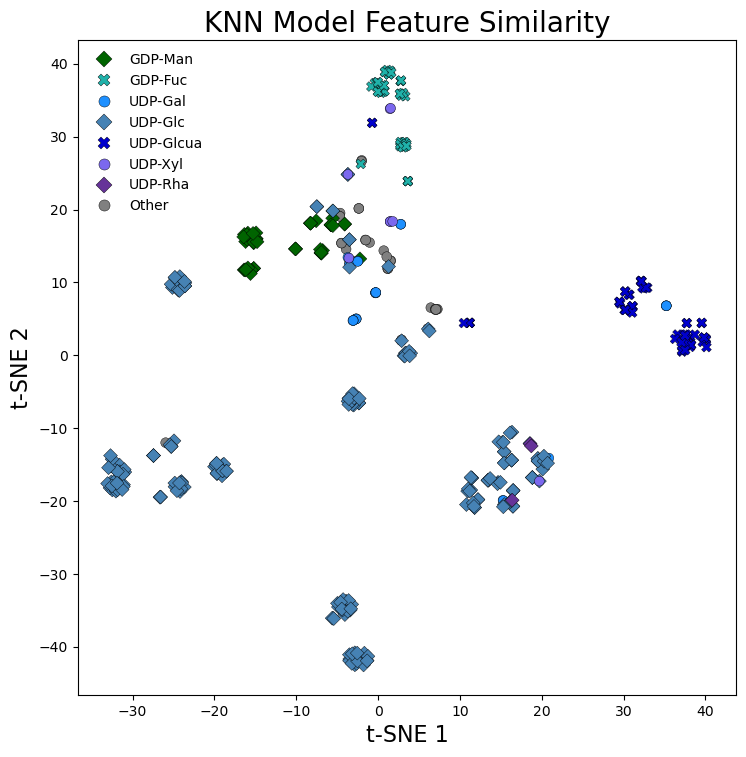

In [99]:
gtb.tsne("KNN")

# Evaluation and Applications

The identity function filters sequences out of the test datset with identity scores above the cutoff.

100%|█████████████████████████████████████████| 100/100 [00:22<00:00,  4.40it/s]


No Ross: 0
No PDB: 0
No Seq: 0
drop: 0
delete: 0
corr: 0


100%|█████████████████████████████████████████| 100/100 [00:20<00:00,  4.97it/s]


No Ross: 0
No PDB: 0
No Seq: 0
drop: 0
delete: 0
corr: 0


100%|█████████████████████████████████████████| 100/100 [00:16<00:00,  5.89it/s]


No Ross: 0
No PDB: 0
No Seq: 0
drop: 0
delete: 0
corr: 0


100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.28it/s]


No Ross: 0
No PDB: 0
No Seq: 0
drop: 0
delete: 0
corr: 0


100%|█████████████████████████████████████████| 100/100 [00:14<00:00,  6.77it/s]


No Ross: 0
No PDB: 0
No Seq: 0
drop: 0
delete: 0
corr: 0


100%|█████████████████████████████████████████| 100/100 [00:13<00:00,  7.37it/s]


No Ross: 0
No PDB: 0
No Seq: 0
drop: 0
delete: 0
corr: 0


100%|█████████████████████████████████████████| 100/100 [00:11<00:00,  8.90it/s]


No Ross: 0
No PDB: 0
No Seq: 0
drop: 0
delete: 0
corr: 0


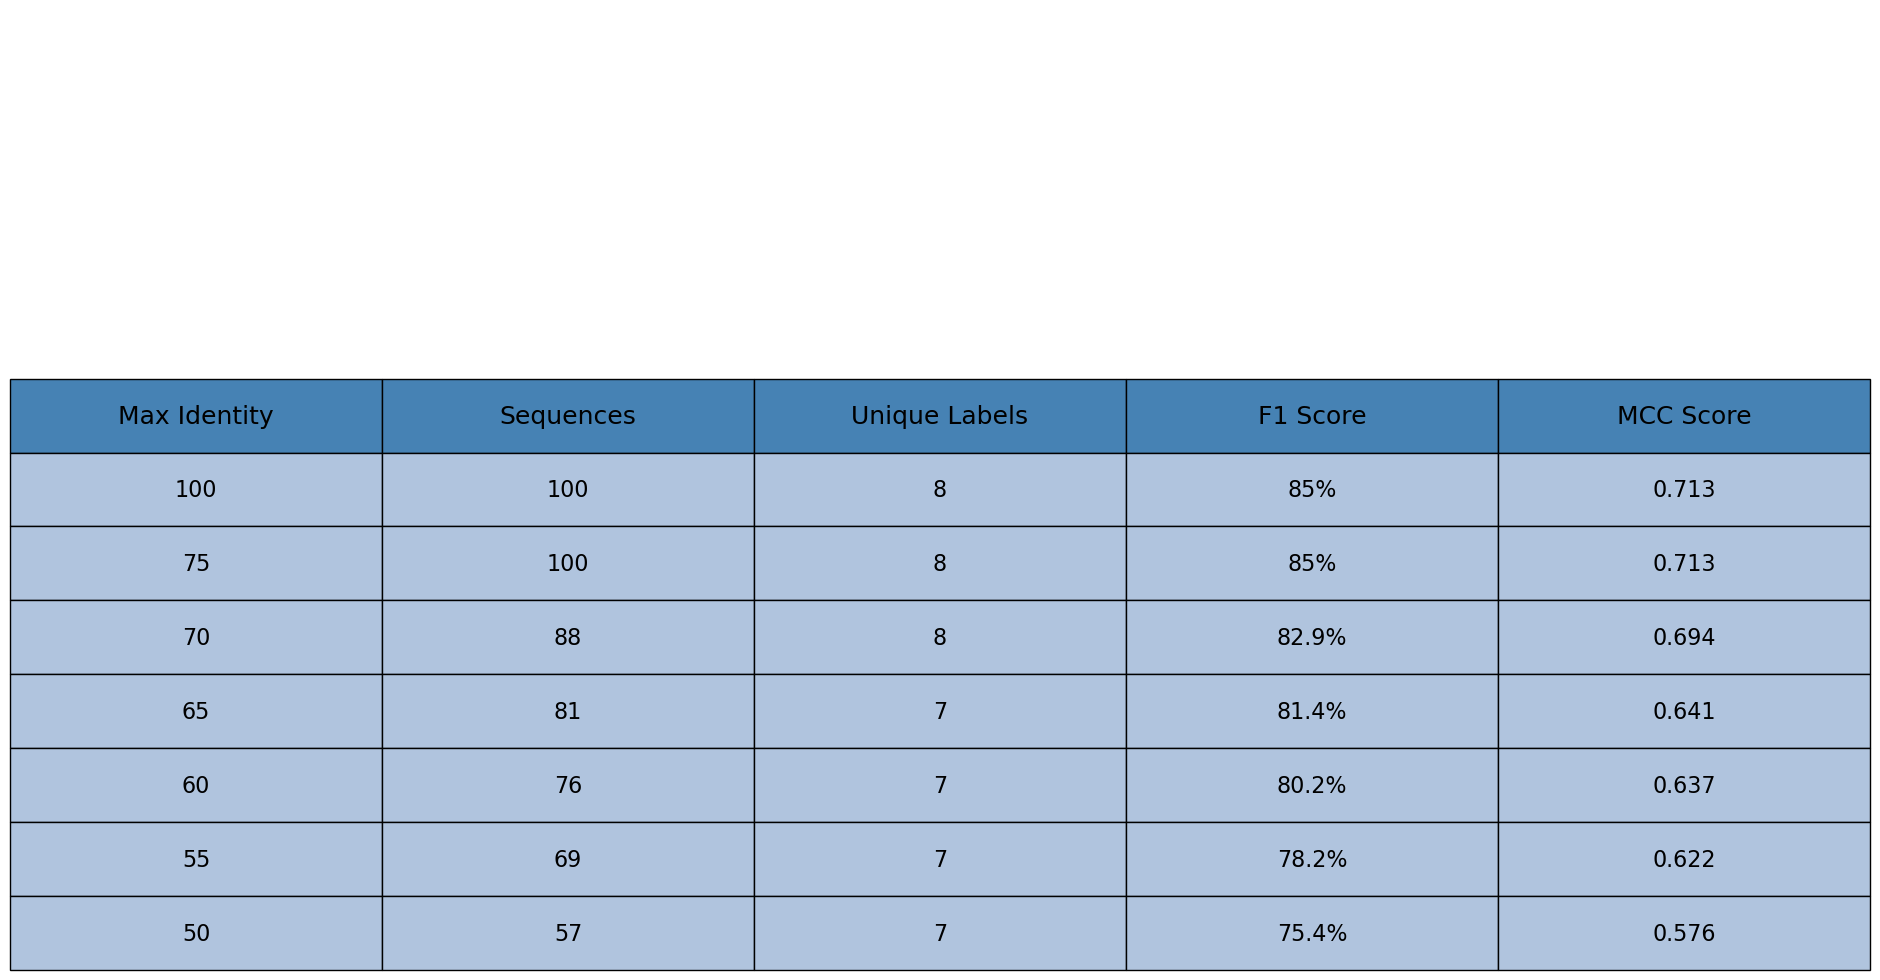

In [82]:
gtb.identity([100,75,70,65,60,55,50],"KNN")

The bins functions make predictions about uncharacterized sequences. 

100%|█████████████████████████████████████████| 983/983 [39:14<00:00,  2.40s/it]


No Ross: 195
No PDB: 480
No Seq: 0
drop: 0
delete: 0
corr: 0
Populus
Total sequences: 308
Predictions: 308
Sequences Predicted: 308
Sequences with Multiple Predictions: 0
------
GDP-alpha-D-mannose: 8
GDP-beta-L-fucose: 48
UDP-alpha-D-glucose: 122
UDP-alpha-D-glucuronate: 2
Eight: 75
UDP-alpha-D-xylose: 25
UDP-alpha-D-galactose: 28


100%|█████████████████████████████████████████| 211/211 [03:00<00:00,  1.17it/s]


No Ross: 64
No PDB: 1
No Seq: 0
drop: 0
delete: 0
corr: 0
Spirodela
Total sequences: 146
Predictions: 146
Sequences Predicted: 146
Sequences with Multiple Predictions: 0
------
GDP-alpha-D-mannose: 1
GDP-beta-L-fucose: 30
UDP-alpha-D-glucose: 81
Eight: 19
UDP-alpha-D-xylose: 6
UDP-alpha-D-galactose: 8
UDP-beta-L-rhamnose: 1


100%|█████████████████████████████████████████| 272/272 [05:07<00:00,  1.13s/it]


No Ross: 102
No PDB: 8
No Seq: 0
drop: 0
delete: 0
corr: 0
Chlamydomonas
Total sequences: 162
Predictions: 162
Sequences Predicted: 162
Sequences with Multiple Predictions: 0
------
GDP-alpha-D-mannose: 5
GDP-beta-L-fucose: 18
UDP-alpha-D-glucose: 39
UDP-alpha-D-glucuronate: 1
Eight: 68
UDP-alpha-D-xylose: 23
UDP-alpha-D-galactose: 8


100%|█████████████████████████████████████████| 465/465 [04:39<00:00,  1.67it/s]


No Ross: 90
No PDB: 0
No Seq: 0
drop: 0
delete: 0
corr: 0
Eucalyptus
Total sequences: 375
Predictions: 375
Sequences Predicted: 375
Sequences with Multiple Predictions: 0
------
GDP-beta-L-fucose: 15
UDP-alpha-D-glucose: 306
Eight: 10
UDP-alpha-D-xylose: 15
UDP-alpha-D-galactose: 19
UDP-beta-L-rhamnose: 10


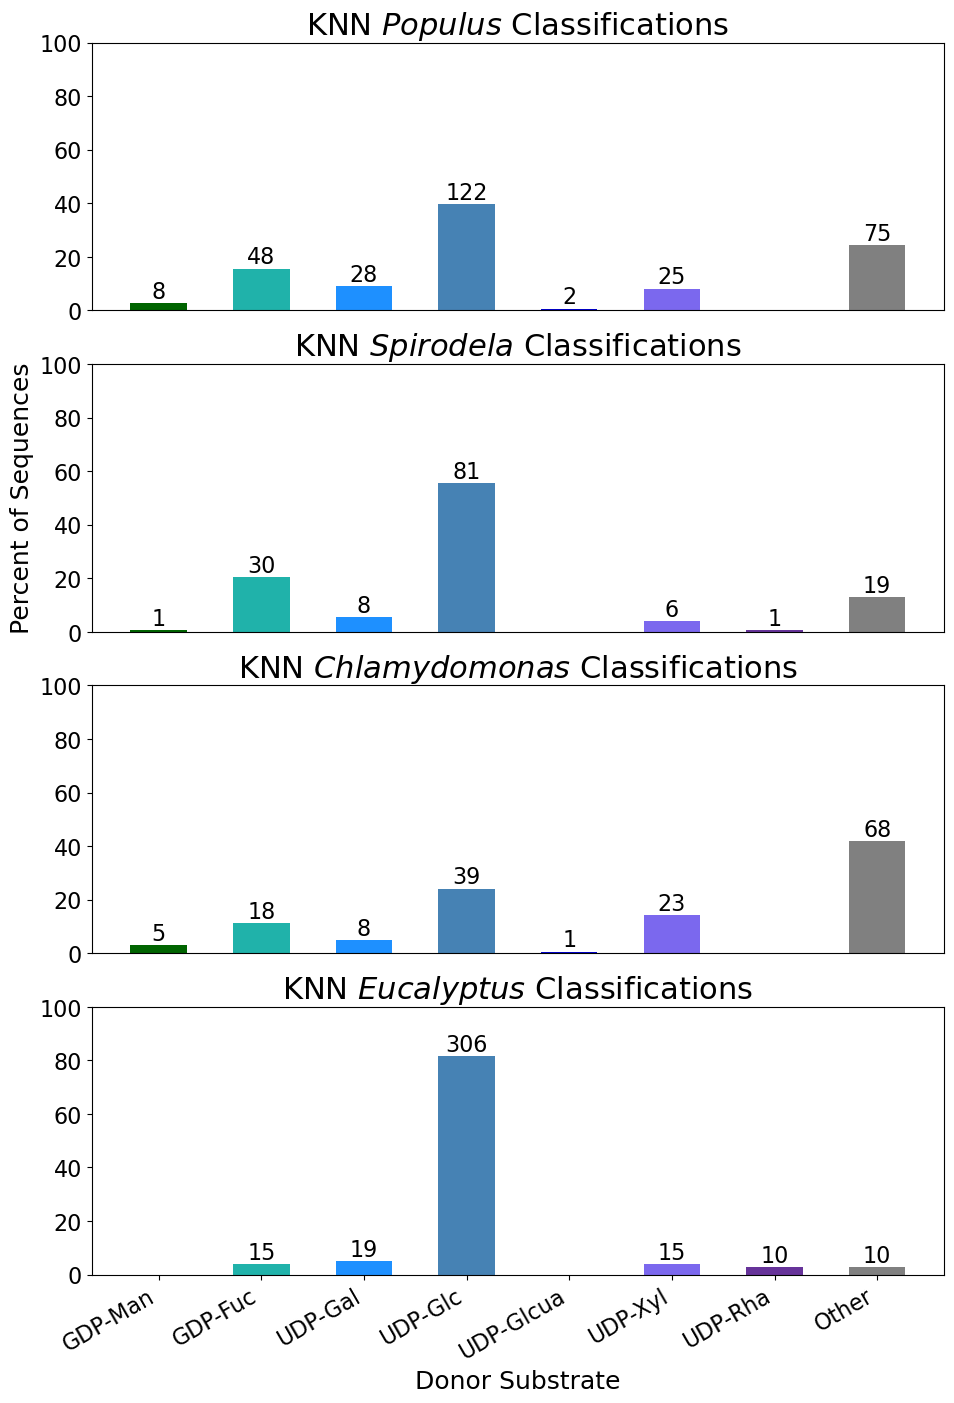

In [83]:
gtb.bins(model_type="KNN",files=["Data/CSV_Files/populus.csv","Data/CSV_Files/spirodela.csv","Data/CSV_Files/chlamydomonas.csv","Data/CSV_Files/eucalyptus.csv"],verbose=True)

# 